In [1]:
from google.colab import drive
drive.mount('/content/drive')
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
import struct as st


Mounted at /content/drive


In [2]:
def read_data(filename):
    file = gzip.open(filename,'rb')
    file.seek(0)
    magic_number = st.unpack('>4B',file.read(4)) # read magic number
    number_of_images = st.unpack('>I',file.read(4))[0] # read number of images
    number_of_rows = st.unpack('>I',file.read(4))[0] #read number of rows
    number_of_columns = st.unpack('>I',file.read(4))[0] #read number of column
    with gzip.open(filename) as file_stream:
        file_stream.read(16)
        buf = file_stream.read(number_of_rows * number_of_columns * number_of_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(number_of_images, number_of_rows,number_of_columns)
        return data

In [3]:
train_data = read_data('/content/train-images-idx3-ubyte.gz')
test_data = read_data('/content/t10k-images-idx3-ubyte.gz')

In [4]:
def read_labels(filename):
    file = gzip.open(filename,'rb')
    file.seek(0)
    magic_number = st.unpack('>4B',file.read(4)) # read magic number
    number_of_iteams = st.unpack('>I',file.read(4))[0] # read number of images
    with gzip.open(filename) as file_stream:
        file_stream.read(8)
        buf = file_stream.read(number_of_iteams)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

In [5]:
train_labels = read_labels('/content/train-labels-idx1-ubyte.gz')
test_labels = read_labels('/content/t10k-labels-idx1-ubyte.gz')

In [6]:
# Create dictionary of target classes
label_dict = {
 0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
}

In [7]:
train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [8]:
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

In [9]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data,
                                                             test_size=0.2,
                                                             random_state=13)

In [11]:
batch_size = 128
epochs = 25
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))
num_classes = 10
n_inputs = train_data.shape[1]

In [12]:


#encoder
conv1 = Conv2D(32, (2, 2), activation='relu', padding='valid',strides=2)(input_img) # 14 x 14 x 32
conv2 = Conv2D(64, (2, 2), activation='relu', padding='valid',strides=2)(conv1) # 7 x 7 x 64
conv3 = Conv2D(128, (2, 2), activation='relu', padding='valid',strides=2)(conv2) # 3 x 3 x 128

# bottleneck
n_bottleneck = 1
bottleneck = Dense(n_bottleneck)(conv2)

flatten = Flatten()(conv3)
encoded = Dense(int(10), activation='relu')(flatten)
decoded = Dense(units = 3*3*128, activation='relu')(encoded)
reshape = Reshape(target_shape = (3,3,128))(decoded)  # 3 x 3 x 128


#decoder
conv4 = Conv2DTranspose(64, (3, 3), activation='relu', padding='valid',strides=2)(reshape) # 7 x 7 x 64
conv5 = Conv2DTranspose(32, (2, 2), activation='relu', padding='valid',strides=2)(conv4) # 14 x 14 x 32
conv6 = Conv2DTranspose(1, (2, 2), activation='sigmoid', padding='valid',strides=2)(conv5) # 28 x 28 x 1


decoded = conv6

In [13]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          8256      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         32896     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                11530     
_________________________________________________________________
dense_2 (Dense)              (None, 1152)              12672 

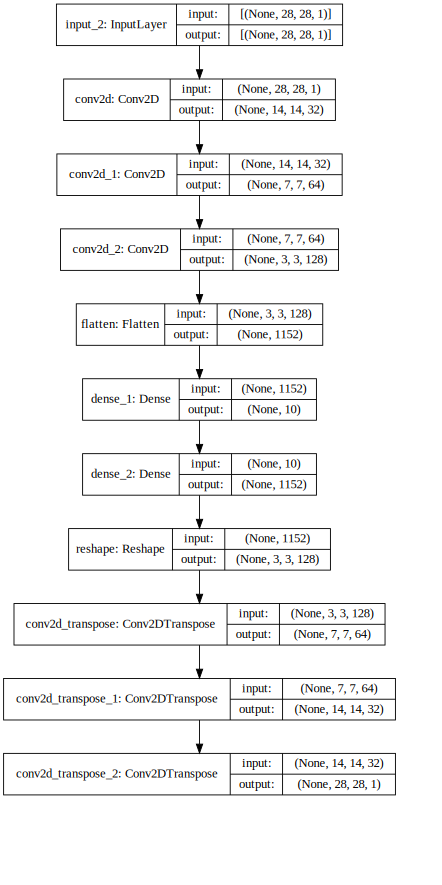

In [14]:
autoencoder.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(autoencoder,show_shapes=True,dpi=65).create(prog='dot', format='svg'))

In [15]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Epoch 1/25
375/375 [==============================] - 10s 6ms/step - loss: 0.0803 - val_loss: 0.0372
Epoch 2/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0328 - val_loss: 0.0272
Epoch 3/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0263 - val_loss: 0.0232
Epoch 4/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0235 - val_loss: 0.0225
Epoch 5/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0218 - val_loss: 0.0205
Epoch 6/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0207 - val_loss: 0.0201
Epoch 7/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0197 - val_loss: 0.0193
Epoch 8/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0190 - val_loss: 0.0188
Epoch 9/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0185 - val_loss: 0.0178
Epoch 10/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0179 - val_loss: 0.018

In [45]:
# define an encoder model (without the decoder)
encoder = Model(inputs=input_img, outputs=bottleneck)

In [46]:
# encode the train data
X_train_encode = encoder.predict(train_data)
X_test_encode = encoder.predict(test_data)

In [47]:
print(X_train_encode.shape)
print(X_test_encode.shape)
print(train_data.shape)

(60000, 7, 7, 1)
(10000, 7, 7, 1)
(60000, 28, 28, 1)


In [48]:
print(train_labels[:10])

[5 0 4 1 9 2 1 3 1 4]


In [49]:
print(X_train_encode[10][1])
print('---------------------')
print(X_train_encode[20][1])

[[-0.06880365]
 [-0.06880365]
 [-0.31675482]
 [ 0.19345757]
 [ 0.9693545 ]
 [-0.06880365]
 [-0.06880365]]
---------------------
[[-0.20490414]
 [ 0.5944595 ]
 [-0.06880365]
 [-0.06880365]
 [-0.69145834]
 [-0.03574254]
 [-0.06880365]]


In [50]:
def normalize(x):
    return (25500*(x - np.min(x))/np.ptp(x)).astype(int)

In [52]:
print(normalize(X_train_encode[10][1]))
print('---------------------')
print(normalize(X_train_encode[20][1]))

[[ 4916]
 [ 4916]
 [    0]
 [10116]
 [25500]
 [ 4916]
 [ 4916]]
---------------------
[[ 9648]
 [25500]
 [12347]
 [12347]
 [    0]
 [13002]
 [12347]]


Na filaksoume tis nees eikones se file gia na tis diavasoume meso tis c++

In [53]:

def saveNewImages(compressedImgs,filename):
  f = open(filename,"w")
  #The first line will contain the number of images
  f.write(str(len(compressedImgs)) + "\n")
  #The second line will contain the number of rows
  f.write(str(len(compressedImgs[0])) + "\n")
  #The third line will contain the number of columns
  f.write(str(len(compressedImgs[0][0])) + "\n")
  #For the rest of the file each line contains the pixels of an image
  #seperated by spaces
  for image in compressedImgs:
    for row in image:
      for pixel in row:
        strPixel = str(pixel)
        strPixel = strPixel.strip('[')
        strPixel = strPixel.strip(']')
        f.write(strPixel + " ")
    f.write("\n")
  f.close()
saveNewImages(normalize(X_train_encode),"trainCompressed")
saveNewImages(normalize(X_test_encode),"testCompressed")

In [ ]:
def saveLabels(labels,filename):
  f = open(filename,"w")
  #First line will contain the number of labels
  f.write(str(len(labels)) + "\n")
  #For the rest of the file each line contains the label of the image
  for label in labels:
    f.write(str(label) + "\n")
  f.close()

saveLabels(train_labels,"trainLabels")
saveLabels(test_labels,"testLabels")